In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['OPENCV_IO_MAX_IMAGE_PIXELS']=str(2**64)
import cv2 as cv
import csv
from statistics import mean
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
with open('data_2_307.csv') as file:
    reader = csv.reader(file)
    
    accel = {'x':[], 'y':[], 'z':[], 't':[]}
    for i, row in enumerate(reader):
        accel['x'].append(float(row[0]))
        accel['y'].append(float(row[1]))
        accel['z'].append(float(row[2]))
        accel['t'].append(int(row[3]))
        
    print('total data:', i)

total data: 466


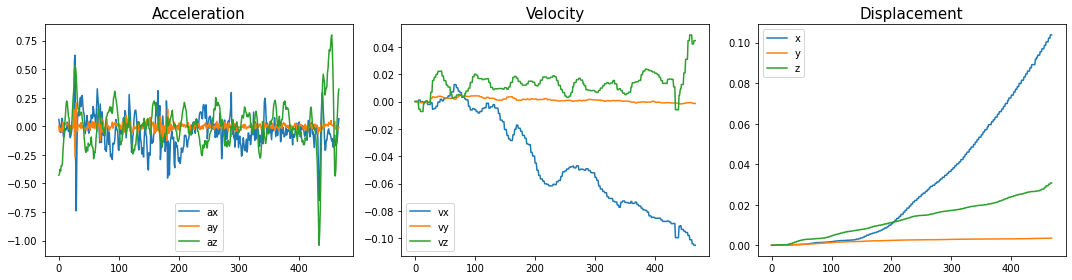

In [ ]:
def plot(data, label, ax, title):
  ax.set_title(title, fontsize=15)
  for i in range(len(data)):
    ax.plot(data[i], label=label[i])
  ax.legend()

x, y, z, vx, vy, vz, t = [0], [0], [0], [0], [0], [0], [0]
for i, ax in enumerate(accel['x']):
  ay = accel['y'][i]
  az = accel['z'][i]

  if i == 0:
      dt = accel['t'][i] * 0.001
  else:
      dt = (accel['t'][i] - accel['t'][i - 1]) * 0.001
  #     dt = 0.004905781584582441
  #     x.append(x[-1] + 0.5 * ax * dt ** 2)
  vx.append(vx[-1] + ax * dt)
  x.append(x[-1] + abs(vx[-1] * dt))

  vy.append(vy[-1] + ay * dt)
  y.append(y[-1] + abs(vy[-1] * dt))

  vz.append(vz[-1] + az * dt)
  z.append(z[-1] + abs(vz[-1] * dt))
  t.append(t[-1] + dt)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))

plot([accel['x'], accel['y'], accel['z']], ['ax', 'ay', 'az'], ax1, 'Acceleration')
plot([vx, vy, vz], ['vx', 'vy', 'vz'], ax2, 'Velocity')
plot([x, y, z], ['x', 'y', 'z'], ax3, 'Displacement')

plt.tight_layout()
plt.show()

In [ ]:
def downsample_image(image, reduce_factor):
	for i in range(0,reduce_factor):
		#Check if image is color or grayscale
		if len(image.shape) > 2:
			row,col = image.shape[:2]
		else:
			row,col = image.shape

		image = cv.pyrDown(image, dstsize= (col//2, row // 2))
	return image

In [ ]:
def compute_depth():
  ret = np.load('camera_params/ret.npy')
  K = np.load('camera_params/K.npy')
  dist = np.load('camera_params/dist.npy')

  img_path1 = 'left_s.jpg'
  img_path2 = 'right_s.jpg'

  img_1 = cv.imread(img_path1)
  img_2 = cv.imread(img_path2)
  img_2 = cv.resize(img_2, (img_1.shape[1], img_1.shape[0]))
  h,w = img_2.shape[:2]

  #Get optimal camera matrix for better undistortion 
  # new_camera_matrix, roi = cv.getOptimalNewCameraMatrix(K,dist,(w,h),1,(w,h))

  #Undistort images
  # img_1_undistorted = cv.undistort(img_1, K, dist, None, new_camera_matrix)
  # img_2_undistorted = cv.undistort(img_2, K, dist, None, new_camera_matrix)

  #Downsample each image 3 times (because they're too big)
  img_1_downsampled = downsample_image(img_1,3)
  img_2_downsampled = downsample_image(img_2,3)

  cv.imwrite('undistorted_left.jpg', img_1_downsampled)
  cv.imwrite('undistorted_right.jpg', img_2_downsampled)

  win_size = 5
  min_disp = -1
  max_disp = 63 #min_disp * 9
  num_disp = max_disp - min_disp # Needs to be divisible by 16

  #Create Block matching object. 
  stereo = cv.StereoSGBM_create(minDisparity= min_disp,
    numDisparities = num_disp,
    blockSize = 5,
    uniquenessRatio = 5,
    speckleWindowSize = 5,
    speckleRange = 5,
    disp12MaxDiff = 2,
    P1 = 8*3*win_size**2,
    P2 =32*3*win_size**2)

  #Compute disparity map
  print ("\nComputing the disparity  map...")
  disparity_map = stereo.compute(img_1_downsampled, img_2_downsampled)

  plt.imshow(disparity_map,'gray')
  plt.show()
  # cv.imwrite('disparity_map.png', disparity_map)

pixel depth: 112


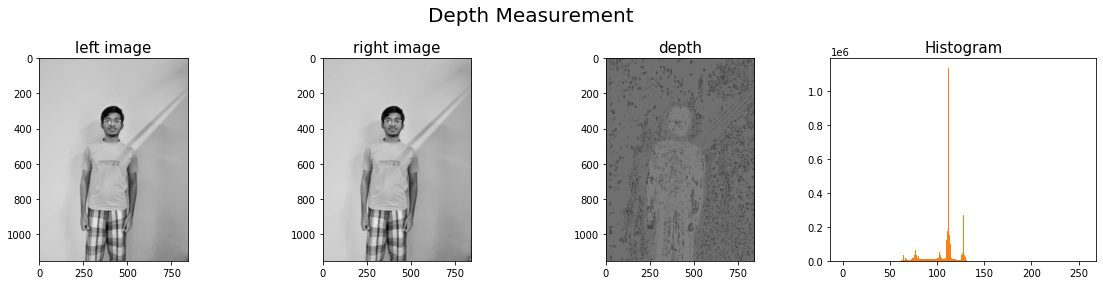

In [ ]:
imgL = cv.imread('left_s.jpg',0)
imgR = cv.imread('right_s.jpg',0)

imgR = cv.resize(imgR, (imgL.shape[1], imgL.shape[0]))
# print(imgL.shape, imgR.shape)
stereo = cv.StereoBM_create(numDisparities=16, blockSize=9)
disparity = stereo.compute(imgL, imgR)

disparity = cv.cvtColor(np.uint8(disparity), cv.COLOR_GRAY2BGR)
out = cv.addWeighted(dst,0.8,disparity,0.2,0)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(16, 4))
fig.suptitle('Depth Measurement', fontsize=20)

ax1.set_title('left image', fontsize=15)
ax1.imshow(imgL, 'gray')

ax2.set_title('right image', fontsize=15)
ax2.imshow(imgR, 'gray')

ax3.set_title('depth', fontsize=15)
ax3.imshow(out)

ax4.set_title('Histogram', fontsize=15)
ax4.hist(out.ravel(), 256, [0,256])
y, x, _ = plt.hist(out.ravel(), 256, [0,256])
print('pixel depth:', np.argmax(y))

plt.tight_layout()
plt.subplots_adjust(top=0.8)
plt.show()

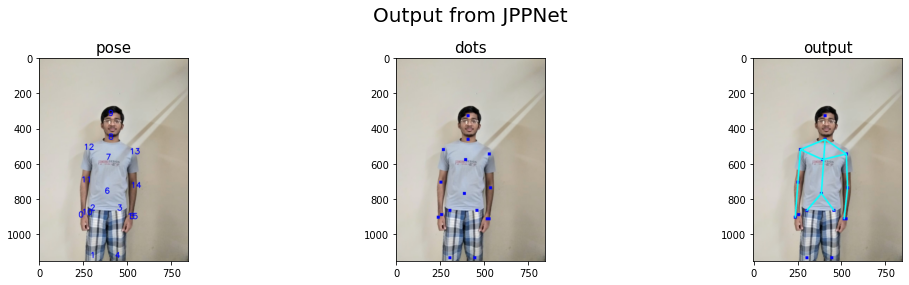

In [ ]:
pose = cv.imread('pose.jpg')
dots = cv.imread('dots.jpg')
output = cv.imread('dots (2).jpg')

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16, 4))
fig.suptitle('Output from JPPNet', fontsize=20)

ax1.set_title('pose', fontsize=15)
ax1.imshow(pose)

ax2.set_title('dots', fontsize=15)
ax2.imshow(dots)

ax3.set_title('output', fontsize=15)
ax3.imshow(output)

plt.tight_layout()
plt.subplots_adjust(top=0.8)
plt.show()

In [ ]:
dist = []
points = [(0, 11), (11, 12), (12, 8), (8, 13), (13, 14), (14, 15), (12, 7), (7, 13), (8, 6), (6, 2), (6, 3)]
with open('dist.npy', 'rb') as f:
  dist = np.load(f)

print('Right Forearm:\t', dist[0], 'px')
print('Right Arm:\t', dist[1], 'px')
print('Left Forearm:\t', dist[5], 'px')
print('Left Arm:\t', dist[4], 'px')
print('Shoulder:\t', dist[2] + dist[3], 'px')
print('Chest:\t\t', dist[6] + dist[7], 'px') 
print('Frontal Length:\t', dist[8] + dist[9]/(2**0.5), 'px')

#Load focal length. 
focal_length = np.load('camera_params/FocalLength.npy')

#Perspective transformation matrix
Q = np.float32([[1,0,0,-w/2.0],
				[0,-1,0,h/2.0],
				[0,0,0,-focal_length],
				[0,0,1,0]])

#Link : https://ags.cs.uni-kl.de/fileadmin/inf_ags/3dcv-ws14-15/3DCV_lec01_camera.pdf
Q2 = np.float32([[1,0,0,0],
				[0,-1,0,0],
				[0,0,focal_length*0.05,0], #Focal length multiplication obtained experimentally. 
				[0,0,0,1]])

dist = dist * 0.137650 
#Reproject points into 3D
points_3D = cv.reprojectImageTo3D(disparity_map, Q2)
#Get color points
colors = cv.cvtColor(img_1_downsampled, cv.COLOR_BGR2RGB)

#Get rid of points with value 0 (i.e no depth)
mask_map = disparity_map > disparity_map.min()

#Mask colors and points. 
output_points = points_3D[mask_map]//2
output_colors = colors[mask_map]

print('\ndistance from camera in meters in m', np.mean(output_points))

print('\nRight Forearm:\t', dist[0], 'cm')
print('Right Arm:\t', dist[1], 'cm')
print('Left Forearm:\t', dist[5], 'cm')
print('Left Arm:\t', dist[4], 'cm')
print('Long Sleeve:\t', (dist[0] + dist[1] + dist[5] + dist[4]) / 2, 'cm')
print('Short Sleeve:\t', (dist[1] + dist[4]) / 4, 'cm')
print('Shoulder:\t', dist[2] + dist[3], 'cm')
print('Chest:\t\t', dist[6] + dist[7], 'cm') 
print('Frontal Length:\t', dist[8] + dist[9]/(2**0.5), 'cm')

Right Forearm:	 199.56452590578317 px
Right Arm:	 185.52897347853784 px
Left Forearm:	 177.02259742756007 px
Left Arm:	 192.12756179163884 px
Shoulder:	 297.4462788636007 px
Chest:		 276.0610876537495 px
Frontal Length:	 396.99225930544736 px

distance from camera in meters in m 2.8420844

Right Forearm:	 27.470056990931052 cm
Right Arm:	 25.53806319932073 cm
Left Forearm:	 24.367160535903643 cm
Left Arm:	 26.446358880619087 cm
Long Sleeve:	 51.91081980338726 cm
Short Sleeve:	 12.996105519984955 cm
Shoulder:	 40.94348028557464 cm
Chest:		 37.99980871553862 cm
Frontal Length:	 54.64598449339482 cm
